# Doublechecking net values

Some people have been [reporting problems](https://github.com/datasciencebr/serenata-de-amor/issues/85) in the value of `net_value` column in the CEAP datasets. It doesn't seem to really match what it should contain.

In [1]:
import pandas as pd
import numpy as np

filenames = ['../data/2016-08-08-current-year.xz',
             '../data/2016-08-08-last-year.xz',
             '../data/2016-08-08-previous-years.xz']
dataset = pd.DataFrame()

for filename in filenames:
    data = pd.read_csv(filename,
                       parse_dates=[16],
                       dtype={'document_id': np.str,
                              'congressperson_id': np.str,
                              'congressperson_document': np.str,
                              'term_id': np.str,
                              'cnpj_cpf': np.str,
                              'reimbursement_number': np.str})
    dataset = pd.concat([dataset, data])

In [2]:
len(dataset)

2072729

In [3]:
dataset['issue_date'] = pd.to_datetime(dataset['issue_date'], errors='coerce')

In [4]:
(dataset['document_value'].isnull()).sum()

17

In [5]:
dataset[dataset['document_value'].isnull()]

document_id       congressperson_name congressperson_id  \
72863       5021378              ALMEIDA LIMA            160626   
72864       5021389              ALMEIDA LIMA            160626   
243933      5028079          CARLOS ZARATTINI            141398   
286036      5028084            DANIEL ALMEIDA             74060   
422966      5062354          ELCIONE BARBALHO             74075   
513864      5073020        FRANCISCO ESCÓRCIO            137983   
652869      5063133        JANETE ROCHA PIETÁ            141455   
670406      5020275           JESUS RODRIGUES            160671   
1031812     5069601  MISSIONÁRIO JOSÉ OLIMPIO            160561   
1095064     5009532            ONYX LORENZONI             74399   
1118504     5030571                PADRE JOÃO            160556   
1180554     5016649               PEDRO HENRY             74111   
1212495     5020247   RAIMUNDO GOMES DE MATOS             74216   
1213738     5020251   RAIMUNDO GOMES DE MATOS             74216   
1214309     5020523   RAIMUNDO GOMES DE MATOS             74216   
1214331     5020531   RAIMUNDO GOMES DE MATOS             74216   
1214332     5020430   RAIMUNDO GOMES DE MATOS             74216   

        congressperson_document    term state  party term_id  subquota_number  \
72863                       173  2011.0    SE   PMDB      54                5   
72864                       173  2011.0    SE   PMDB      54                5   
243933                      398  2015.0    SP     PT      55               10   
286036                      188  2015.0    BA  PCdoB      55                3   
422966                       21  2015.0    PA   PMDB      55               13   
513864                      567  2011.0    MA   PMDB      54                3   
652869                      358  2011.0    SP     PT      54               15   
670406                      115  2011.0    PI     PT      54                4   
1031812                     375  2015.0    SP    DEM      55                3   
1095064                     510  2015.0    RS    DEM      55                3   
1118504                     259  2015.0    MG     PT      55                3   
1180554                     403  2011.0    MT     PP      54                9   
1212495                     102  2015.0    CE   PSDB      55                1   
1213738                     102  2015.0    CE   PSDB      55                8   
1214309                     102  2015.0    CE   PSDB      55               10   
1214331                     102  2015.0    CE   PSDB      55               10   
1214332                     102  2015.0    CE   PSDB      55               10   

                                     subquota_description      ...       \
72863                 Publicity of parliamentary activity      ...        
72864                 Publicity of parliamentary activity      ...        
243933                                  Telecommunication      ...        
286036                               Fuels and lubricants      ...        
422966                                Congressperson meal      ...        
513864                               Fuels and lubricants      ...        
652869            Aircraft renting or charter of aircraft      ...        
670406           Consultancy, research and technical work      ...        
1031812                              Fuels and lubricants      ...        
1095064                              Fuels and lubricants      ...        
1118504                              Fuels and lubricants      ...        
1180554                                    Flight tickets      ...        
1212495    Participation in course, talk or similar event      ...        
1213738  Security service provided by specialized company      ...        
1214309                                 Telecommunication      ...        
1214331                                 Telecommunication      ...        
1214332                                 Telecommunication      ... 

In [6]:
dataset[dataset['document_value'].isnull()].iloc[0]

document_id                                               5021378
congressperson_name                                  ALMEIDA LIMA
congressperson_id                                          160626
congressperson_document                                       173
term                                                         2011
state                                                          SE
party                                                        PMDB
term_id                                                        54
subquota_number                                                 5
subquota_description          Publicity of parliamentary activity
subquota_group_id                                               0
subquota_group_description                                    NaN
supplier                                        JULIANO AMADEU ME
cnpj_cpf                                           11901432000190
document_number                                          00000007
document_t

Since we expect precision in our `net_value` calculation, I'm going to use integers and not floats.

In [7]:
import math

dataset = dataset.dropna(subset=['document_value'])
dataset['document_value_int'] = (dataset['document_value'] * 100.).apply(math.ceil).astype(np.int)
dataset['remark_value_int'] = (dataset['remark_value'] * 100.).apply(math.ceil).astype(np.int)
dataset['net_value_int'] = (dataset['net_value'] * 100.).apply(math.ceil).astype(np.int)
dataset['calc_net_value_int'] = dataset['document_value_int'] - dataset['remark_value_int']

In [8]:
((dataset['calc_net_value_int'] - dataset['net_value_int']) != 0).sum()

21434

In [9]:
dataset.iloc[0]

document_id                                                             5928744
congressperson_name                                           ABEL MESQUITA JR.
congressperson_id                                                        178957
congressperson_document                                                       1
term                                                                       2015
state                                                                        RR
party                                                                       DEM
term_id                                                                      55
subquota_number                                                               1
subquota_description          Maintenance of office supporting parliamentary...
subquota_group_id                                                             0
subquota_group_description                                                  NaN
supplier                                

In [10]:
dataset['diff_net_value'] = dataset['net_value_int'] - dataset['calc_net_value_int']
dataset.loc[dataset['diff_net_value'] != 0, 'diff_net_value'].describe()

count    2.143400e+04
mean    -6.495887e+04
std      3.402186e+05
min     -9.712858e+06
25%     -1.086200e+04
50%      1.000000e+00
75%      1.000000e+00
max      1.763608e+06
Name: diff_net_value, dtype: float64

What's the number of records with distinct values of `net_value` and our own `net_value`, considering acceptable a maximum difference of 2 cents?

In [11]:
with_significant_difference = dataset.loc[dataset['diff_net_value'].abs() > 2]

In [12]:
with_significant_difference['subquota_description'].describe()

count                    9457
unique                     17
top       Flight ticket issue
freq                     4319
Name: subquota_description, dtype: object

It's not just a single subquota, but almost all of them. Probably means that there's something intrinsic in the dataset we still don't know. 

In [13]:
print(len(dataset['subquota_description'].unique()))
print(len(with_significant_difference['subquota_description'].unique()))

18
17


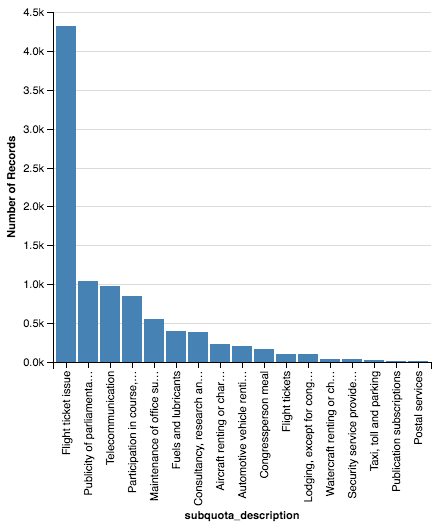

In [14]:
from altair import *

Chart(with_significant_difference).mark_bar().encode(
    x=X('subquota_description:O',
        sort=SortField(field='subquota_description',
                       order='descending',
                       op='count')),
    y='count(*):Q',
)

In [15]:
with_significant_difference['subquota_description'].unique()

array(['Security service provided by specialized company',
       'Fuels and lubricants', 'Publicity of parliamentary activity',
       'Automotive vehicle renting or charter',
       'Maintenance of office supporting parliamentary activity',
       'Telecommunication', 'Congressperson meal',
       'Taxi, toll and parking',
       'Consultancy, research and technical work',
       'Lodging, except for congressperson from Distrito Federal',
       'Flight tickets', 'Publication subscriptions',
       'Flight ticket issue', 'Aircraft renting or charter of aircraft',
       'Participation in course, talk or similar event', 'Postal services',
       'Watercraft renting or charter'], dtype=object)

I want to perform a further investigation in flight ticket issues, since [it's already documented](http://jarbas.datasciencebr.com/static/ceap-datasets.html) that `net_value`'s may be negative given canceled flights.

In [16]:
flight_ticket_issues = with_significant_difference['subquota_description'] == 'Flight ticket issue'
with_significant_difference.loc[flight_ticket_issues, 'net_value'].head(10)

37628     1870.16
49896      815.26
49922      839.32
62640     -480.58
62641      961.16
65229       58.00
77422      495.16
78867     1329.26
101579     260.00
116316     298.89
Name: net_value, dtype: float64

Here we have 3 documents with `reimbursement_number` equal to zero. How about disconsidering them to start? If there's no `reimbursement_number`, we could assume that no reimbursement happened (if the data says data, the Chamber of Deputies should be contacted to confirm the affirmation).

In [17]:
with_significant_difference.loc[flight_ticket_issues & \
                                (with_significant_difference['congressperson_id'] == '178983')]

document_id congressperson_name congressperson_id  \
116316         NaN       MARCIO ALVINO            178983   
116333         NaN       MARCIO ALVINO            178983   
116396         NaN       MARCIO ALVINO            178983   

       congressperson_document    term state party term_id  subquota_number  \
116316                     370  2015.0    SP    PR      55              999   
116333                     370  2015.0    SP    PR      55              999   
116396                     370  2015.0    SP    PR      55              999   

       subquota_description       ...        leg_of_the_trip batch_number  \
116316  Flight ticket issue       ...                BSB/GRU            0   
116333  Flight ticket issue       ...                BSB/GRU            0   
116396  Flight ticket issue       ...                BSB/GRU            0   

       reimbursement_number reimbursement_value applicant_id  \
116316                    0                 NaN         3061   
116333                    0                 NaN         3061   
116396                    0                 NaN         3061   

        document_value_int remark_value_int  net_value_int  \
116316                9963                0          29889   
116333                9963                0          29889   
116396               17063                0          34126   

        calc_net_value_int  diff_net_value  
116316                9963           19926  
116333                9963           19926  
116396               17063           17063  

[3 rows x 34 columns]

In [18]:
dataset['reimbursement_number'] = \
    dataset['reimbursement_number'].replace('0', None)
dataset = dataset.dropna(subset=['reimbursement_number'])

In [19]:
dataset['document_id'].isnull().sum()

972391

In [20]:
with_significant_difference = dataset.loc[dataset['diff_net_value'].abs() > 2]
len(with_significant_difference)

9307

In [21]:
flight_ticket_issues = with_significant_difference['subquota_description'] == 'Flight ticket issue'
with_significant_difference.loc[flight_ticket_issues].head()

document_id    congressperson_name congressperson_id  \
37628         NaN     CLARISSA GAROTINHO            178939   
49896         NaN          DULCE MIRANDA            178994   
49922         NaN          DULCE MIRANDA            178994   
62640         NaN  FÉLIX MENDONÇA JÚNIOR            160666   
62641         NaN  FÉLIX MENDONÇA JÚNIOR            160666   

      congressperson_document    term state party term_id  subquota_number  \
37628                     294  2015.0    RJ    PR      55              999   
49896                      61  2015.0    TO  PMDB      55              999   
49922                      61  2015.0    TO  PMDB      55              999   
62640                     195  2015.0    BA   PDT      55              999   
62641                     195  2015.0    BA   PDT      55              999   

      subquota_description       ...        leg_of_the_trip batch_number  \
37628  Flight ticket issue       ...                SDU/BSB            0   
49896  Flight ticket issue       ...                BSB/PMW            0   
49922  Flight ticket issue       ...                PMW/BSB            0   
62640  Flight ticket issue       ...                SSA/BSB            0   
62641  Flight ticket issue       ...                SSA/BSB            0   

      reimbursement_number reimbursement_value applicant_id  \
37628                 5506                 NaN         3036   
49896                 5440                 NaN         2905   
49922                 5440                 NaN         2905   
62640                 5463                 NaN         2307   
62641                 5463                 NaN         2307   

       document_value_int remark_value_int  net_value_int  calc_net_value_int  \
37628               93508                0         187016               93508   
49896               40763                0          81526               40763   
49922               41966                0          83932               41966   
62640              -24029                0         -48058              -24029   
62641               48058                0          96116               48058   

       diff_net_value  
37628           93508  
49896           40763  
49922           41966  
62640          -24029  
62641           48058  

[5 rows x 34 columns]

In [22]:
with_significant_difference.loc[flight_ticket_issues].iloc[0]

document_id                                   NaN
congressperson_name            CLARISSA GAROTINHO
congressperson_id                          178939
congressperson_document                       294
term                                         2015
state                                          RJ
party                                          PR
term_id                                        55
subquota_number                               999
subquota_description          Flight ticket issue
subquota_group_id                               0
subquota_group_description                    NaN
supplier                          Cia Aérea - GOL
cnpj_cpf                           07575651000159
document_number                   Bilhete: CGB8TZ
document_type                                   0
issue_date                    2016-04-07 00:00:00
document_value                             935.08
remark_value                                    0
net_value                                 1870.16


In [23]:
dataset[(dataset['congressperson_name'] == 'CLARISSA GAROTINHO') & \
        (dataset['month'] == 4) & \
        (dataset['year'] == 2016) & \
        (dataset['subquota_description'] == 'Flight ticket issue')]['net_value_int'].sum()

794619

In [24]:
dataset.loc[dataset['document_number'] == 'Bilhete: VHVK6G']

document_id congressperson_name congressperson_id  \
37661         NaN  CLARISSA GAROTINHO            178939   
37662         NaN  CLARISSA GAROTINHO            178939   
37663         NaN  CLARISSA GAROTINHO            178939   

      congressperson_document    term state party term_id  subquota_number  \
37661                     294  2015.0    RJ    PR      55              999   
37662                     294  2015.0    RJ    PR      55              999   
37663                     294  2015.0    RJ    PR      55              999   

      subquota_description       ...        leg_of_the_trip batch_number  \
37661  Flight ticket issue       ...                BSB/SDU            0   
37662  Flight ticket issue       ...                BSB/SDU            0   
37663  Flight ticket issue       ...                BSB/BSB            0   

      reimbursement_number reimbursement_value applicant_id  \
37661                 5506                 NaN         3036   
37662                 5506                 NaN         3036   
37663                 5506                 NaN         3036   

       document_value_int remark_value_int  net_value_int  calc_net_value_int  \
37661               73813                0          73813               73813   
37662               73813                0          73813               73813   
37663              -51363                0         -51363              -51363   

       diff_net_value  
37661               0  
37662               0  
37663               0  

[3 rows x 34 columns]

In [25]:
dataset.loc[dataset['document_number'] == 'Bilhete: VHVK6G'].iloc[0]

document_id                                   NaN
congressperson_name            CLARISSA GAROTINHO
congressperson_id                          178939
congressperson_document                       294
term                                         2015
state                                          RJ
party                                          PR
term_id                                        55
subquota_number                               999
subquota_description          Flight ticket issue
subquota_group_id                               0
subquota_group_description                    NaN
supplier                          Cia Aérea - GOL
cnpj_cpf                           07575651000159
document_number                   Bilhete: VHVK6G
document_type                                   0
issue_date                    2016-04-13 00:00:00
document_value                             738.13
remark_value                                    0
net_value                                  738.13


In [26]:
dataset.loc[dataset['document_number'] == 'Bilhete: VHVK6G'].iloc[1]

document_id                                   NaN
congressperson_name            CLARISSA GAROTINHO
congressperson_id                          178939
congressperson_document                       294
term                                         2015
state                                          RJ
party                                          PR
term_id                                        55
subquota_number                               999
subquota_description          Flight ticket issue
subquota_group_id                               0
subquota_group_description                    NaN
supplier                          Cia Aérea - GOL
cnpj_cpf                           07575651000159
document_number                   Bilhete: VHVK6G
document_type                                   0
issue_date                    2016-04-13 00:00:00
document_value                             738.13
remark_value                                    0
net_value                                  738.13


In [27]:
dataset.loc[dataset['document_number'] == 'Bilhete: VHVK6G'].iloc[2]

document_id                                   NaN
congressperson_name            CLARISSA GAROTINHO
congressperson_id                          178939
congressperson_document                       294
term                                         2015
state                                          RJ
party                                          PR
term_id                                        55
subquota_number                               999
subquota_description          Flight ticket issue
subquota_group_id                               0
subquota_group_description                    NaN
supplier                          Cia Aérea - GOL
cnpj_cpf                           07575651000159
document_number                   Bilhete: VHVK6G
document_type                                   0
issue_date                    2016-04-19 00:00:00
document_value                            -513.63
remark_value                                    0
net_value                                 -513.63


The dataset contains multiple records for the same `document_number`. In this case, they correspond to multiple flight tickets to the same flight, but for distinct passengers.

In [28]:
dataset.loc[dataset['document_number'] == 'Bilhete: VHVK6G',
            ['document_value_int', 'remark_value_int', 'document_number', 'reimbursement_number', 'passenger', 'net_value_int', 'calc_net_value_int']]

document_value_int  remark_value_int  document_number  \
37661               73813                 0  Bilhete: VHVK6G   
37662               73813                 0  Bilhete: VHVK6G   
37663              -51363                 0  Bilhete: VHVK6G   

      reimbursement_number            passenger  net_value_int  \
37661                 5506   CLARISSA GAROTINHO          73813   
37662                 5506  SAMPAIO/ANACAROLINA          73813   
37663                 5506   CLARISSA GAROTINHO         -51363   

       calc_net_value_int  
37661               73813  
37662               73813  
37663              -51363

http://jarbas.datasciencebr.com/#/document_id/5914504

These documents seem to correspond to the same receipt. The reimbursements were claimed in the same `batch_number` but in distinct reimbursements (`reimbursement_number`).

Together, `document_value`, `remark_value` and `net_value` make sense.

In [29]:
with_significant_difference[with_significant_difference['document_id'] == '5914504']

document_id congressperson_name congressperson_id congressperson_document  \
27     5914504   ABEL MESQUITA JR.            178957                       1   
28     5914504   ABEL MESQUITA JR.            178957                       1   

      term state party term_id  subquota_number  \
27  2015.0    RR   DEM      55                8   
28  2015.0    RR   DEM      55                8   

                                subquota_description       ...        \
27  Security service provided by specialized company       ...         
28  Security service provided by specialized company       ...         

    leg_of_the_trip batch_number reimbursement_number reimbursement_value  \
27              NaN      1264155                 5381                 NaN   
28              NaN      1264155                 5386                 NaN   

   applicant_id  document_value_int remark_value_int  net_value_int  \
27         3074              850000                0          20000   
28         3074              850000                0         830000   

    calc_net_value_int  diff_net_value  
27              850000         -830000  
28              850000          -20000  

[2 rows x 34 columns]

The Chamber of Deputies just use `applicant_id`, `year` and `document_id` when refering to a reimbursement. If all of them together count as a single reimbursement, an expense is an aggregation of all rows with the same above. attributes.

Let's prove the affirmation above analysing the whole dataset and checking if the values make more sense after.

In [30]:
data_with_id = dataset[(~dataset['document_id'].isnull()) &
                       (~dataset['year'].isnull()) &
                       (~dataset['applicant_id'].isnull())]

In [ ]:
keys = ['applicant_id', 'year', 'document_id']
grouped = data_with_id.groupby(keys)
len(grouped)

1097629

In [ ]:
reimbursement_numbers = grouped['reimbursement_number'].agg(lambda x: ','.join(set(x))).reset_index()
agg_net_values_int = grouped['net_value_int'].agg(np.sum).reset_index()

In [ ]:
agg_net_values_int.head()

In [ ]:
agg_data = pd.merge(pd.merge(reimbursement_numbers, agg_net_values_int, on=keys),
                    data_with_id,
                    on=keys,
                    suffixes=('', '_from_original'))
agg_data.head()

There are 2,072,559 documents in the datasets, but when considering just the combination of non-empty values for `applicant_id`, `year` and `document_id`, half of that is found. In other words, the CEAP seem to have paid for about 1MM expenses so far.

In [ ]:
len(agg_data)

In [ ]:
agg_data.drop_duplicates(subset=keys, inplace=True)

len(agg_data)

In [ ]:
agg_data.drop(['reimbursement_number_from_original',
               'net_value_int_from_original'],
              axis=1,
              inplace=True)

In [ ]:
agg_data['document_value_int'] = (agg_data['document_value'] * 100.).apply(math.ceil).astype(np.int)
agg_data['remark_value_int'] = (agg_data['remark_value'] * 100.).apply(math.ceil).astype(np.int)
# agg_data['net_value_int'] = (agg_data['net_value'] * 100.).apply(math.ceil).astype(np.int)
agg_data['calc_net_value_int'] = agg_data['document_value_int'] - agg_data['remark_value_int']
agg_data['diff_net_value'] = agg_data['net_value_int'] - agg_data['calc_net_value_int']

In [ ]:
with_significant_difference = agg_data.loc[agg_data['diff_net_value'].abs() > 2]

Disconsidering multiple records with this same combination, just 744 remain with a large difference between our own calculation of `net_value`s and the value directly in the original dataset.

In [ ]:
len(with_significant_difference)

The majority of records were explained by the previous test, having all the flight ticket issues disappeared (though a few "Flight tickets" remain).

In [ ]:
Chart(with_significant_difference).mark_bar().encode(
    x=X('subquota_description:O',
        sort=SortField(field='subquota_description',
                       order='descending',
                       op='count')),
    y='count(*):Q',
)

In [ ]:
agg_data[agg_data['reimbursement_number'].str.contains(',')]

The document with major positive difference in the dataset doesn't seem to have any irregularity. The deputy asked the reimbursement for R\$ 25.000,00, but received just R\$ 6.376,11.

In [ ]:
with_significant_difference.sort_values('diff_net_value').iloc[0]

Deputies receiving less money than they asked is OK. What if they are receiving more than they should (values in the `document_value` column)?

In [ ]:
has_extra_reimbursement = with_significant_difference['diff_net_value'] > 0
extra_reimbursement = with_significant_difference[has_extra_reimbursement]. \
    sort_values('diff_net_value', ascending=False)
len(extra_reimbursement)

In [ ]:
extra_reimbursement.head()

In [ ]:
Chart(extra_reimbursement).mark_bar().encode(
    x=X('subquota_description:O',
        sort=SortField(field='subquota_description',
                       order='descending',
                       op='count')),
    y='count(*):Q',
)

In [ ]:
extra_reimbursement.sort_values('diff_net_value', ascending=False).iloc[0]

This document says that a deputy received R\$ 3.226,59 more than it should. Let's check all the datasets we have to see if there's any mistake in the calculation.

In [ ]:
dataset[dataset['document_id'] == '5951638']

In [ ]:
data_with_id[data_with_id['document_id'] == '5951638']

In [ ]:
extra_reimbursement[extra_reimbursement['document_id'] == '5951638']

In [ ]:
extra_reimbursement[extra_reimbursement['document_id'] == '5951638'].iloc[0]

Doesn't seem to have. Calculations are doing what it's expected and are following our understanding of the dataset.

There's a possibility that this extra payment counted towards other requests for reimbursements. Let's check.

In [ ]:
dataset[(dataset['applicant_id'] == 2899) & \
        (dataset['subquota_number'] == 3) & \
        (dataset['year'] == 2016) & \
        (dataset['month'].isin([1, 2, 3]))]

Can't see anything proving that. Going to analize the next reimbursement.

In [ ]:
extra_reimbursement.sort_values('diff_net_value', ascending=False).iloc[1]

In [ ]:
(extra_reimbursement['remark_value'] > 0).sum()

Nope. Not a clue.

In [ ]:
extra_reimbursement.sort_values('diff_net_value', ascending=False).iloc[2]

Not yet.

In [ ]:
extra_reimbursement.sort_values('diff_net_value', ascending=False).iloc[3]